## Marjan Farsi - Group 12 - Storm Dataset (2020 - 2025)- Group Project Task 2 - Dist. Computing


## Query : Map or group by state (or region) to compare which states see more tornadoes more severe tornadoes.

In [72]:
#!pip install google-cloud-storage
#!pip install matplotlib


### Create small dataset with 5000 record (one time run)

In [73]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("StormApp1").getOrCreate()

# # Load as Spark DataFrame
df = spark.read.csv("storm_g2020.csv", header=True, inferSchema=True)

# Get top 5000 records
#df_small = init_df.limit(5000)

#df_small.coalesce(1).write.csv("top5000_temp", header=True, mode="overwrite")

### Data Cleansing -> Replace null values in associated columns ("EVENT_TYPE" , "STATE",  "TOR_F_SCALE" ) with safe values for each column

In [74]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, avg, count, round, desc, lit

# Clean EVENT_TYPE
df = df.withColumn(
    "EVENT_TYPE",
    when(col("EVENT_TYPE").isNull(), lit("Unknown")).otherwise(col("EVENT_TYPE"))
)

# Clean STATE
df = df.withColumn(
    "STATE",
    when(col("STATE").isNull(), lit("Unknown")).otherwise(col("STATE"))
)

# Clean TOR_F_SCALE (keep categorical!)
df = df.withColumn(
    "TOR_F_SCALE",
    when(col("TOR_F_SCALE").isNull(), lit("EF0")).otherwise(col("TOR_F_SCALE"))
)

df.show()


+---------------+---------+----------+-------------+-------+--------+----------+--------+--------+----------+----+----------+-----------------+-------+-------+----------+---+------------------+-----------+------------------+---------------+-----------------+-------------+---------------+---------------+------------+---------------+---------+--------------+-----------+--------+-----------+----------+---------+-------------+------------------+-----------------+-----------------+-----------+-------------+-------------------+---------+-----------+-------------------+---------+---------+-------+---------+--------------------+--------------------+-----------+
|BEGIN_YEARMONTH|BEGIN_DAY|BEGIN_TIME|END_YEARMONTH|END_DAY|END_TIME|EPISODE_ID|EVENT_ID|   STATE|STATE_FIPS|YEAR|MONTH_NAME|       EVENT_TYPE|CZ_TYPE|CZ_FIPS|   CZ_NAME|WFO|   BEGIN_DATE_TIME|CZ_TIMEZONE|     END_DATE_TIME|INJURIES_DIRECT|INJURIES_INDIRECT|DEATHS_DIRECT|DEATHS_INDIRECT|DAMAGE_PROPERTY|DAMAGE_CROPS|         SOURCE|MAGNI

### We produce two maps (tables):

### Tornado Frequency Map

→ Which states see more tornadoes?

### Tornado Severity Map

→ Which states see more severe tornadoes (EF3–EF5)?

### Then we produce a combined summary.

In [75]:
from pyspark.sql.functions import col, count, avg, desc
from pyspark.sql.functions import round

# Filter only tornado events
tornado_df = df.filter(col("EVENT_TYPE") == "Tornado")

#Count tornado by State
state_tornado_frequency = (
    tornado_df.groupBy("STATE")
              .agg(count("*").alias("tornado_count"))
              .orderBy(desc("tornado_count"))
)

# States with more severe tornados: Severe tornadoes are EF3, EF4, EF5

severe_df = tornado_df.filter(col("TOR_F_SCALE").isin("EF3","EF4","EF5"))

state_severe_frequency = (
    severe_df.groupBy("STATE")
             .agg(count("*").alias("severe_tornado_count"))
             .orderBy(desc("severe_tornado_count"))
)

# Combine Both Metrics (tabeles): Frequency + Severity
summary = (
    state_tornado_frequency.join(state_severe_frequency, on="STATE", how="left")
                           .fillna(0)   # fill states with no EF3+ tornadoes
                           .orderBy(desc("tornado_count"))
)

# In the table below, 10 top states with both, more number of tornado and more severe tornado in descending order are displayed (state with most number of Tornado and most severe one is on the top)
summary.show(10, truncate=False)


+-----------+-------------+--------------------+
|STATE      |tornado_count|severe_tornado_count|
+-----------+-------------+--------------------+
|TEXAS      |663          |24                  |
|MISSISSIPPI|660          |24                  |
|ILLINOIS   |607          |6                   |
|ALABAMA    |543          |17                  |
|OKLAHOMA   |505          |16                  |
|IOWA       |477          |13                  |
|FLORIDA    |365          |5                   |
|GEORGIA    |348          |10                  |
|LOUISIANA  |337          |7                   |
|MISSOURI   |334          |20                  |
+-----------+-------------+--------------------+
only showing top 10 rows


/var/folders/32/rscq9lcj483dff3_k4sczht80000gn/T/ipykernel_47296/3844012509.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


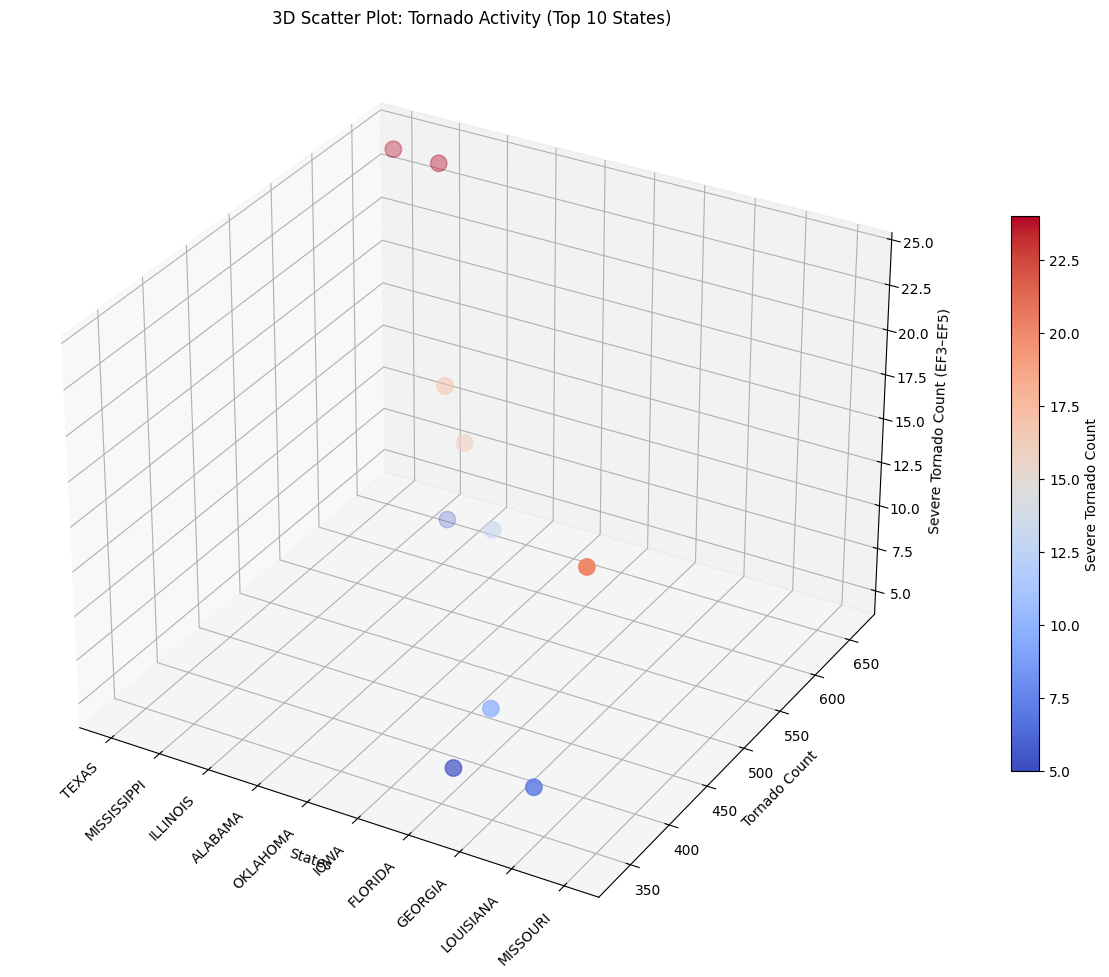

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


top10_pdf = summary.orderBy("tornado_count", ascending=False).limit(10).toPandas()


# Extract fields
states = top10_pdf["STATE"].tolist()
tornado_counts = top10_pdf["tornado_count"].tolist()
severe_counts = top10_pdf["severe_tornado_count"].tolist()

# Numeric X positions for states
x = np.arange(len(states))

# Create 3D figure
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# 3D Scatter
sc = ax.scatter(
    x, tornado_counts, severe_counts,
    c=severe_counts, cmap="coolwarm", s=140
)

# Labels and titles
ax.set_xlabel("States")
ax.set_ylabel("Tornado Count")
ax.set_zlabel("Severe Tornado Count (EF3–EF5)")
ax.set_title("3D Scatter Plot: Tornado Activity (Top 10 States)")

# Replace X ticks with state names
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=45, ha='right')

plt.colorbar(sc, ax=ax, shrink=0.6, label="Severe Tornado Count")
plt.tight_layout()
plt.show()



/var/folders/32/rscq9lcj483dff3_k4sczht80000gn/T/ipykernel_47296/666590598.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


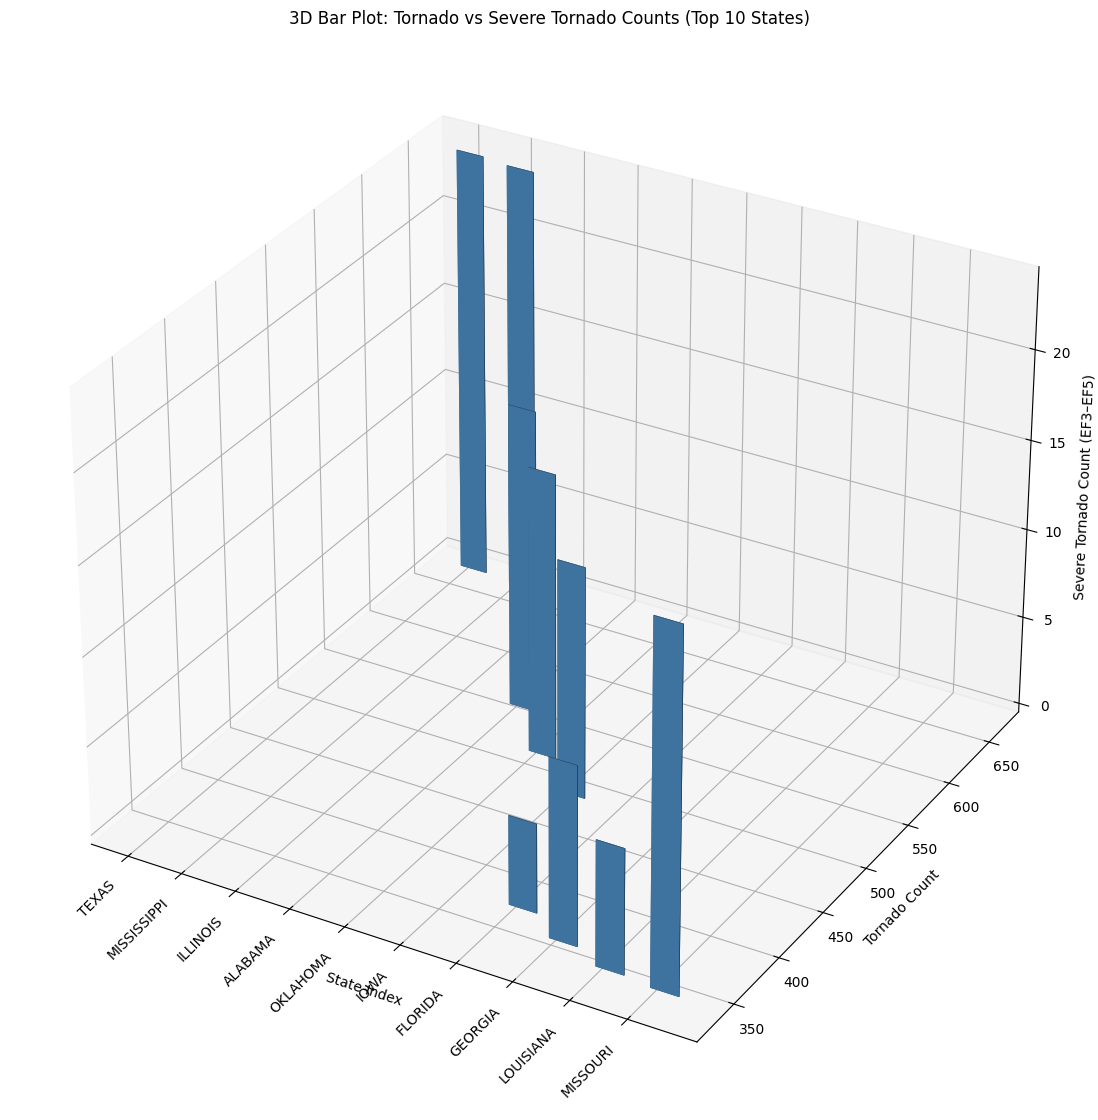

In [77]:
fig = plt.figure(figsize=(22, 14))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(len(states))
y = tornado_counts
z = np.zeros(len(states))  # base level

dx = np.ones(len(states)) * 0.5
dy = np.ones(len(states)) * 0.5
dz = severe_counts

# 3D Bars
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color="steelblue")

ax.set_xlabel("State Index")
ax.set_ylabel("Tornado Count")
ax.set_zlabel("Severe Tornado Count (EF3–EF5)")
ax.set_title("3D Bar Plot: Tornado vs Severe Tornado Counts (Top 10 States)")

ax.set_xticks(x)
ax.set_xticklabels(states, rotation=45, ha='right')

plt.tight_layout()
plt.show()
